In [571]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
import pandas as pd
import string
import contractions
from gensim.models import KeyedVectors
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import sacrebleu
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

In [184]:
# Load the dataset
file_path = "english_urdu_1000+.csv"  # Adjust path if needed
dataset = pd.read_csv(file_path)

# Prepare the data
input_texts = dataset["English"].values
target_texts = dataset["Urdu"].values
total_sentences = input_texts.size

In [187]:
def clean_text(np_array):
    # Function to clean text: remove punctuation and expand contractions
    cleaned_text = []
    
    # Iterate over each string in the numpy array
    for text in np_array:

        # Text lower-cased
        text_lowered = text.lower()

        # Remove punctuation
        text_no_punct = text_lowered.translate(str.maketrans('', '', string.punctuation))
        
        # Expand contractions
        text_expanded = contractions.fix(text_no_punct)
        
        # Append cleaned text to the list
        cleaned_text.append(text_expanded)
    
    return np.array(cleaned_text)

In [194]:
input_cleaned = clean_text(input_texts)

In [238]:
def remove_urdu_punctuation(np_array):
    # Function to clean text: remove punctuation and expand contractions
    cleaned_text = []

    urdu_punctuations = [
        '۔', '،', '؟', '؍', '؏', 'ؒ', '۝', 'ۖ', 'ۚ', 'ۛ', 'ۜ', '۝', '۞', '۟', '۠'
    ]
    
    # Iterate over each string in the numpy array
    for text in np_array:

        # Create a regex pattern that matches any Urdu punctuation
        pattern = f"[{''.join(urdu_punctuations)}]"
        
        cleaned_text.append(re.sub(pattern, '', text))
    
    return np.array(cleaned_text)

In [240]:
target_cleaned = remove_urdu_punctuation(target_texts)

In [ ]:
model_path = 'urduvec_140M_100K_300d.bin'   # Download from this link: "https://github.com/samarh/urduvec"

# Load the Word2Vec model
word2vec_urdu = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
model_path = 'GoogleNews-vectors-negative300-SLIM.bin'  # Download from this link: "https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz"

# Load the Word2Vec model
word2vec_eng = KeyedVectors.load_word2vec_format(model_path, binary=True)


In [237]:
urdu_embedding_size = word2vec_urdu.vector_size
sos_vector = np.random.uniform(-0.25, 0.25, urdu_embedding_size)  # Random initialization
eos_vector = np.random.uniform(-0.25, 0.25, urdu_embedding_size)  # Random initialization
unk_vector = np.random.uniform(-0.25, 0.25, urdu_embedding_size)  # Random initialization
pad_vector = np.zeros(urdu_embedding_size)  # Zero vector for padding

word2vec_urdu.add_vector('<unk>', unk_vector)
word2vec_urdu.add_vector('<pad>', pad_vector)
word2vec_urdu.add_vector('<sos>', unk_vector)
word2vec_urdu.add_vector('<eos>', pad_vector)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


102217

In [ ]:
# Adding special tokens to embedding

# Define the embedding size (for the GoogleNews vectors, it's 300)
eng_embedding_size = word2vec_eng.vector_size

# Initialize the <unk> and <pad> vectors (either zero or random)
unk_vector = np.random.uniform(-0.25, 0.25, eng_embedding_size)  # Random initialization
pad_vector = np.zeros(eng_embedding_size)  # Zero vector for padding

# Add <unk> and <pad> to the model's vocabulary
word2vec_eng.add_vector('<unk>', unk_vector)
word2vec_eng.add_vector('<pad>', pad_vector)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


299569

In [ ]:
def to_indexed(input_sentences, word2vec, add_special_tokens=False):
    max_length = 0
    indexed_sentences = []
    vocab = {'<pad>': 0, '<unk>': 1}
    vocab_idx = 1
    embeddings = [
        word2vec[word2vec.key_to_index['<pad>']].T, # 0
        word2vec[word2vec.key_to_index['<unk>']].T  # 1
    ]
    if add_special_tokens:
        vocab['<sos>'] = 2
        vocab['<eos>'] = 3
        embeddings.append(word2vec[word2vec.key_to_index['<sos>']].T)  # 2
        embeddings.append(word2vec[word2vec.key_to_index['<eos>']].T)  # 3
        vocab_idx = 3
    for sentence in input_sentences:
        indexed_sentence = []
        if add_special_tokens:
            indexed_sentence.append(vocab['<sos>'])
        sentence = sentence.strip().split()
        sen_len = len(sentence)
        if sen_len > max_length:
            max_length = sen_len
        # Replace words with indices, use <unk> if word is not in vocabulary
        for word in sentence:
            if word in word2vec.key_to_index:
                if word in vocab:
                    indexed_sentence.append(vocab[word])
                else:
                    vocab_idx += 1
                    vocab[word] = vocab_idx
                    embeddings.append(word2vec[word2vec.key_to_index[word]].T)
            else:
                indexed_sentence.append(vocab['<unk>'])  # Use <unk> if word is missing
        if add_special_tokens:
            indexed_sentence.append(vocab['<eos>'])
        indexed_sentences.append(indexed_sentence)
    
    if add_special_tokens:
        max_length += 2

    for i in range(len(indexed_sentences)):
        diff = max_length - len(indexed_sentences[i])
        if diff > 0:
            for _ in range(diff):
                indexed_sentences[i].append(vocab['<pad>'])

    indexed_sentences = np.array(indexed_sentences)
    embeddings = np.array(embeddings)

    return indexed_sentences, embeddings, vocab, max_length

In [304]:
input_indexed, embeddings_input, vocab_input, max_length_input = to_indexed(input_cleaned, word2vec=word2vec_eng)
target_indexed, embeddings_target, vocab_target, max_length_target = to_indexed(target_cleaned, word2vec=word2vec_urdu, add_special_tokens=True)

In [415]:
input_vocab_size = len(vocab_input)
target_vocab_size = len(vocab_target)
idx_to_urdu = {i: word for word, i in vocab_target.items()}

In [294]:
input_train, input_test, target_train, target_test = train_test_split(input_indexed, target_indexed, test_size=0.2, random_state=20)

In [ ]:
class BLEUScoreCallback(Callback):
    def __init__(self, val_data, index_to_word, batch_size=64):
        super(BLEUScoreCallback, self).__init__()
        self.val_data = val_data
        self.index_to_word = index_to_word
        self.batch_size = batch_size

    def convert_to_words(self, seq):
        # Convert integer sequence to words using the index_to_word mapping
        words = [self.index_to_word[int(idx)] for idx in seq]
        return " ".join(words)

    def compute_bleu_score(self, y_pred, y_true):
        # Convert predicted and true sequences to words
        y_pred_words = [self.convert_to_words(seq) for seq in y_pred]
        y_true_words = [self.convert_to_words(seq) for seq in y_true]

        # Compute BLEU score using sacrebleu
        bleu_score = sacrebleu.corpus_bleu(y_pred_words, [y_true_words])
        return bleu_score.score

    def on_epoch_end(self, epoch, logs=None):
        # Get the validation data (encoder inputs, decoder inputs, and decoder targets)
        val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = self.val_data

        # Predict using the model on the validation data
        y_pred = self.model.predict([val_encoder_input_data, val_decoder_input_data], batch_size=self.batch_size, verbose=0)

        # Compute BLEU score
        bleu_score = self.compute_bleu_score(np.argmax(y_pred, axis=-1), val_decoder_target_data)
        logs['val_bleu_score'] = bleu_score

In [ ]:
# Define the model
latent_dim = 64

# Encoder
encoder_inputs = Input(shape=(None,))   # Defines input sequence of variable length
encoder_embedding = Embedding(input_vocab_size, eng_embedding_size, weights=[embeddings_input], trainable=False, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=False)
_, state_h, state_c = encoder_lstm(encoder_embedding)  # state_h, state_c from last token of sequence in encoder (context vectors)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, urdu_embedding_size, weights=[embeddings_target], trainable=False, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)   # Returns state_h, state_c for all sequences
decoder_dense = Dense(target_vocab_size, activation='softmax')  # Dense layer for creating probabilities for words in the vocabulary
decoder_outputs = decoder_dense(decoder_outputs)

encoder_input_data = np.copy(input_train)
decoder_input_data = np.copy(target_train)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]     # Given an input to the decoder it predicts the next token in the decoder_input_data


# Assuming test data is indexed similarly to training data
test_encoder_input_data = np.copy(input_test)
test_decoder_input_data = np.copy(target_test)

# Create decoder target data for test set
test_decoder_target_data = np.zeros_like(test_decoder_input_data)
test_decoder_target_data[:, :-1] = test_decoder_input_data[:, 1:]


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Instantiate the BLEU score callback
bleu_callback = BLEUScoreCallback(
    val_data=(test_encoder_input_data, test_decoder_input_data, test_decoder_target_data),
    index_to_word=idx_to_urdu,  # A function or dictionary to map indices to words
    batch_size=64
)

# Train the model
history = model.fit([encoder_input_data, decoder_input_data],
          decoder_target_data,
          batch_size=64,
          epochs=50,
          validation_data=([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          callbacks=[bleu_callback])

# Inference Models for Encoding and Decoding

# Encoder Model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder Model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm_outputs, state_h, state_c = decoder_lstm(               # decoder_lstm_outputs has h,c for all sequences. state_h, state_c are after last token
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_lstm_outputs)   # decoder_lstm_outputs passes through dense layer to give probabilities for words in the vocabulary
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [655]:
training_ds_loss_history = history.history['loss']
testing_ds_loss_history = history.history['val_loss']

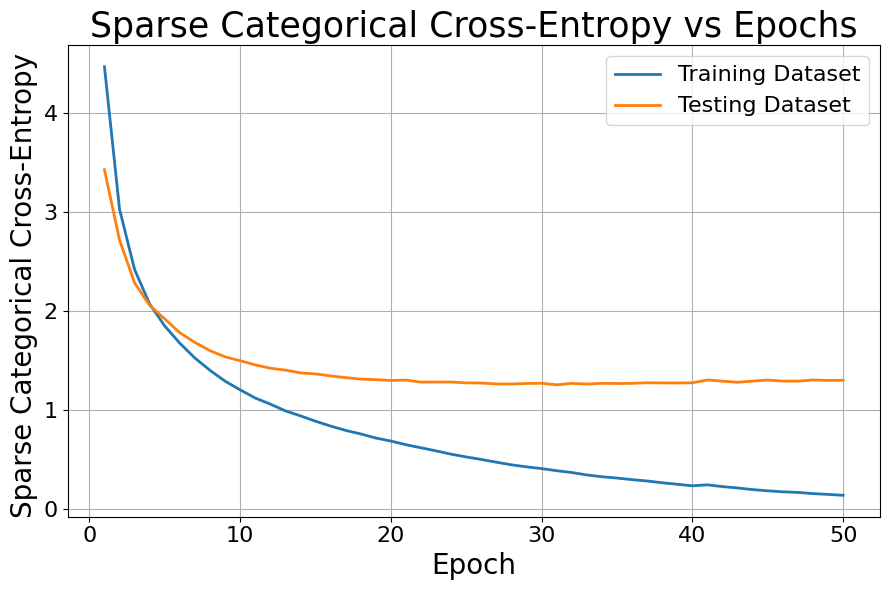

In [656]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Sparse Categorical Cross-Entropy vs Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Sparse Categorical Cross-Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig('scce.png', dpi=300)
plt.show()

In [657]:
def compute_bleu_score(y_pred, y_true, idx_to_word):

    def convert_to_words(seq):
        # Convert integer sequence to words using the index_to_word mapping
        words = [idx_to_word[int(idx)] for idx in seq]
        return " ".join(words)
    
    # Convert predicted and true sequences to words
    y_pred_words = [convert_to_words(seq) for seq in y_pred]
    y_true_words = [convert_to_words(seq) for seq in y_true]

    # Compute BLEU score using sacrebleu
    bleu_score = sacrebleu.corpus_bleu(y_pred_words, [y_true_words])
    return bleu_score.score

In [690]:
training_loss, training_accuracy = model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, verbose=0)
print(f"Training Dataset Accuracy: {training_accuracy * 100:.2f}% | Training Dataset Loss (SCCE): {training_loss:.4f}")

Training Dataset Accuracy: 98.93% | Training Dataset Loss (SCCE): 0.1212


In [658]:
test_loss, test_accuracy = model.evaluate([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data, verbose=0)
print(f"Testing Dataset Accuracy: {test_accuracy * 100:.2f}% | Testing Dataset Loss (SCCE): {test_loss:.4f}")

Testing Dataset Accuracy: 89.16% | Testing Dataset Loss (SCCE): 1.2997


In [659]:
y_pred = model.predict([test_encoder_input_data, test_decoder_input_data], verbose=0)
predicted_word_indices = np.argmax(y_pred, axis=-1)

In [660]:
bleu_score = compute_bleu_score(predicted_word_indices, test_decoder_target_data, idx_to_urdu)
print(f"Testing Dataset BLEU score: {bleu_score:.4f}")

Testing Dataset BLEU score: 91.6024


In [661]:
def preprocess_input_sentence(sentence, word_to_idx):
    sentence = sentence.lower()
    # Remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    
    # Expand contractions
    sentence = contractions.fix(sentence)
    sentence = sentence.strip().split()
    sentence_indexed = []
    for i in range(len(sentence)):
        if sentence[i] in word_to_idx:
            sentence_indexed.append(word_to_idx[sentence[i]])
        else:
            print(f'''Warning: "{sentence[i]}" is not in the vocabulary''')
            sentence_indexed.append(word_to_idx['<unk>'])
    return sentence_indexed

In [662]:
def decode_sequence(input_seq, idx_to_urdu, max_target_len):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Initialize target sequence with the first word (start-of-sequence token)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = vocab_target['<sos>']  # Ensure <sos> is in your target vocabulary

    decoded_sentence = ''

    while True:
        # Predict the next word
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get the token with the highest probability
        predicted_token_index = np.argmax(output_tokens[0, -1, :])
        predicted_word = idx_to_urdu[predicted_token_index]

        # Append the predicted word to the output
        if predicted_word == '<eos>':
            break  # Stop decoding when <eos> is predicted
        elif predicted_token_index == 0:
            break   # Stop decoding when <pad> is predicted
        else:
            decoded_sentence += ' ' + predicted_word

        # Update the target sequence with the predicted word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_token_index

        # Update states
        states_value = [h, c]

        # Stop decoding if the maximum target length is reached
        if len(decoded_sentence.split()) >= max_target_len:
            break

    return decoded_sentence.strip()

In [709]:
sentence = "I am sorry"
sentence_indexed = preprocess_input_sentence(sentence, vocab_input)
sentence_indexed = np.array(sentence_indexed).reshape(1, -1)
print('Translation:')
decode_sequence(sentence_indexed, idx_to_urdu, max_length_target)

Translation:


'مجھے افسوس ہے'

In [711]:
# Save the models
encoder_model.save('encoder_model.keras')
decoder_model.save('decoder_model.keras')

print("Models saved successfully!")

Models saved successfully!


### Accuracy, BLEU Score Figures Generation Ahead

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(go.Indicator(
#     mode="gauge+number",
#     value=test_accuracy * 100,
#     title={'text': "Model Accuracy for Test Set"},
#     number={'suffix': "%"},
#     gauge={
#         'axis': {'range': [0, 100]},
#         'bar': {'color': "green"},
#         'steps': [
#             {'range': [0, 50], 'color': "lightcoral"},
#             {'range': [50, 70], 'color': "#FFA500"},
#             {'range': [70, 80], 'color': "yellow"},  # Yellow for range 70-80
#             {'range': [80, 90], 'color': "lightgreen"},  # Light green for range 80-90
#             {'range': [90, 100], 'color': "green"}  # Darker green for range 90-100
#         ],
#     }
# ))

# fig.update_layout(
#     width=600,
#     height=400,
# )
# fig.write_image("accuracy.png", scale=2)
# fig.show()


In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(go.Indicator(
#     mode="gauge+number",
#     value=bleu_score,
#     title={'text': "Model BLEU Score for Test Set"},
#     number={'suffix': "%"},
#     gauge={
#         'axis': {'range': [0, 100]},
#         'bar': {'color': "darkgreen"},
#         'steps': [
#             {'range': [0, 50], 'color': "lightcoral"},
#             {'range': [50, 70], 'color': "#FFA500"},
#             {'range': [70, 80], 'color': "yellow"},  # Yellow for range 70-80
#             {'range': [80, 90], 'color': "lightgreen"},  # Light green for range 80-90
#             {'range': [90, 100], 'color': "green"}  # Darker green for range 90-100
#         ],
#     }
# ))

# fig.update_layout(
#     width=600,
#     height=400,
# )
# # fig.write_image("bleu_score.png", scale=2)
# fig.show()
